Here, we are benchmarking how Bayesian optimization from the [Optuna](https://optuna.readthedocs.io/en/stable/index.html) package performs in comparison to the more specialized Bayesian optimization framework [BoTorch]() at optimizing a publicly available dataset related to the design of a reinforced concrete beam. An implementation of this problem can be found [here](https://github.com/ryojitanabe/reproblems/blob/master/reproblem_python_ver/reproblem.py) and was described in this publication:
- [Tanabe & Ishibuchi, An Easy-to-use Real-world Multi-objective Problem Suite. ArXiv, **2020**](https://arxiv.org/pdf/2009.12867)

This real-world benchmark problem has three numerical input variables: area of reinforcement, depth, and width of the beam, and the goal is to minimize the two target variables price and reinforcement measure.

In [1]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.utils.transforms import unnormalize, normalize
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
import numpy as np
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.hypervolume import Hypervolume
import matplotlib.pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import infer_reference_point
import optuna
from copy import deepcopy
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", ".*A not p.d., added jitter of")
warnings.filterwarnings("ignore", ".*Optimization failed")
warnings.filterwarnings("ignore", ".*is an experimental feature")

print("BoTorch version:", botorch.__version__, "PyTorch version:", torch.__version__)
print("Optuna version:", optuna.__version__)

n_startup = 10 
n_exps_ = 30
n_repeats = 200
batch_size = 1
ref_point = [-200., -600.]

results_random = np.zeros((n_repeats, n_exps_, 3))
results_optuna = np.zeros((n_repeats, n_exps_, 3))
results_botorch = np.zeros((n_repeats, n_exps_, 3))
n_exps = n_startup + int((n_exps_ - n_startup) / batch_size)


# https://github.com/ryojitanabe/reproblems/blob/master/reproblem_python_ver/reproblem.py
class RE22():
    def __init__(self):
        self.problem_name = "RE22"
        self.n_objectives = 2
        self.n_variables = 3
        self.n_constraints = 0
        self.n_original_constraints = 2
        
        self.bounds = np.array([
            [0.201, 0.001, 0.001],
            [14.999, 19.999, 39.999]
            ])
        self.bounds_norm = np.zeros_like(self.bounds)
        self.bounds_norm[1, :] = 1.

        self.feasible_vals = np.array([0.20, 0.31, 0.40, 0.44, 0.60, 0.62, 0.79, 0.80, 0.88, 0.93, 1.0, 1.20, 1.24, 1.32, 1.40, 1.55, 1.58, 1.60, 1.76, 1.80, 1.86, 2.0, 2.17, 2.20, 2.37, 2.40, 2.48, 2.60, 2.64, 2.79, 2.80, 3.0, 3.08, 3,10, 3.16, 3.41, 3.52, 3.60, 3.72, 3.95, 3.96, 4.0, 4.03, 4.20, 4.34, 4.40, 4.65, 4.74, 4.80, 4.84, 5.0, 5.28, 5.40, 5.53, 5.72, 6.0, 6.16, 6.32, 6.60, 7.11, 7.20, 7.80, 7.90, 8.0, 8.40, 8.69, 9.0, 9.48, 10.27, 11.0, 11.06, 11.85, 12.0, 13.0, 14.0, 15.0])
            
    def evaluate(self, arr):
        out = np.zeros((arr.shape[0], 2))

        for idx0, x in enumerate(arr):
            f = np.zeros(self.n_objectives)
            g = np.zeros(self.n_original_constraints)
            #Reference: getNearestValue_sample2.py (https://gist.github.com/icchi-h/1d0bb1c52ebfdd31f14b3e811328390a)
            idx = np.abs(np.asarray(self.feasible_vals) - x[0]).argmin()
            x1 = self.feasible_vals[idx]
            x2 = x[1]
            x3 = x[2]
    
            #First original objective function
            f[0] = (29.4 * x1) + (0.6 * x2 * x3)
    
            # Original constraint functions 	
            g[0] = (x1 * x3) - 7.735 * ((x1 * x1) / x2) - 180.0
            g[1] = 4.0 - (x3 / x2)
            g = np.where(g < 0, -g, 0)          
            f[1] = g[0] + g[1]
            out[idx0, :] = f
        return out
    
    
    def sample_random(self, n_samples):
        X = np.stack([
            np.random.uniform(self.bounds[0, 0], self.bounds[1, 0], n_samples),
            np.random.uniform(self.bounds[0, 1], self.bounds[1, 1], n_samples),
            np.random.uniform(self.bounds[0, 2], self.bounds[1, 2], n_samples),
            ], axis=-1)
        return X


re22 = RE22()

C:\Users\User\anaconda3\envs\botorchv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BoTorch version: 0.12.0 PyTorch version: 2.3.0
Optuna version: 4.0.0


# Random sampling

In [2]:
hv = Hypervolume(torch.tensor(ref_point))

for idx0 in range(n_repeats):
    X_train = re22.sample_random(n_exps_)
    y_train = re22.evaluate(X_train)
    results_random[idx0, :y_train.shape[0], :2] = y_train
        
    for idx1 in range(n_exps_):
        pareto_idx = is_non_dominated(-torch.from_numpy(y_train[:idx1+1, :])).tolist()
        pareto_pts =  y_train[:idx1+1, :][pareto_idx]
        results_random[idx0, idx1, 2] = hv.compute(-torch.from_numpy(pareto_pts))

# Bayesian optimization with Optuna

In [3]:
sampler = optuna.samplers.TPESampler(multivariate=True, n_startup_trials=n_startup)

for idx0 in range(n_repeats):
    _sampler = deepcopy(sampler)
    study = optuna.create_study(sampler=_sampler, directions=["minimize", "minimize"])
   
    for idx1 in range(int(n_exps_ / batch_size)):
        trials = [study.ask() for x in range(batch_size)]
        pars = []
        for idx2 in range(batch_size):
            x0 = trials[idx2].suggest_float("x0", low=re22.bounds[0, 0], high=re22.bounds[1, 0], step=0.001)
            x1 = trials[idx2].suggest_float("x1", low=re22.bounds[0, 1], high=re22.bounds[1, 1], step=0.001)
            x2 = trials[idx2].suggest_float("x2", low=re22.bounds[0, 2], high=re22.bounds[1, 2], step=0.001)
            pars.append([x0, x1, x2])
            
        for idx2 in range(batch_size):
            study.tell(trials[idx2], re22.evaluate(np.array([pars[idx2]])).tolist()[0])
        
    results_optuna[idx0, :, :2] = study.trials_dataframe()[["values_0", "values_1"]].values

    for idx3 in range(n_exps_):
        pareto_idx = is_non_dominated(-torch.from_numpy(results_optuna[idx0, :idx3+1, :2])).tolist()
        pareto_pts = results_optuna[idx0, :idx3+1, :2][pareto_idx]
        results_optuna[idx0, idx3, 2] = hv.compute(-torch.from_numpy(pareto_pts))

# Bayesian optimization with BoTorch

In [4]:
for idx0 in range(n_repeats):
    X_train = re22.sample_random(n_startup)
    y_train = re22.evaluate(X_train)
    with torch.no_grad():
        ref_point_adapt = infer_reference_point(torch.from_numpy(-y_train)).tolist()
    
    for idx1 in range(n_exps - n_startup):
        models = []
        for idx2 in range(y_train.shape[-1]):
            models.append(
                SingleTaskGP(
                    train_X=torch.from_numpy(X_train),
                    train_Y=torch.from_numpy(y_train[:, idx2:idx2+1]),
                    input_transform=Normalize(d=X_train.shape[-1]),
                    outcome_transform=Standardize(m=1),
                    )
                )
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        acq_func = qLogNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point_adapt,
            X_baseline=normalize(
                torch.from_numpy(X_train), 
                torch.from_numpy(re22.bounds)),
            )
        
        candidate, acq_value = optimize_acqf(
            acq_func, 
            bounds=torch.from_numpy(re22.bounds_norm), 
            q=batch_size, 
            num_restarts=5, 
            raw_samples=64,
        )
    
        candidate = unnormalize(candidate, torch.from_numpy(re22.bounds))
        
        X_train = np.vstack((X_train, candidate.numpy()))
        y_train = np.vstack((y_train, re22.evaluate(candidate.numpy())))
        
        with torch.no_grad():
            ref_point = infer_reference_point(torch.from_numpy(-y_train)).tolist()
        
        results_botorch[idx0, :y_train.shape[0], :2] = y_train
        
    for idx3 in range(n_exps_):
        pareto_idx = is_non_dominated(-torch.from_numpy(y_train[:idx3+1, :])).tolist()
        pareto_pts = y_train[:idx3+1, :][pareto_idx]
        results_botorch[idx0, idx3, 2] = hv.compute(-torch.from_numpy(pareto_pts))

C:\Users\User\anaconda3\envs\botorchv2\lib\site-packages\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\User\anaconda3\envs\botorchv2\lib\site-packages\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


# Results
BoTorch massively outperforms Optuna:

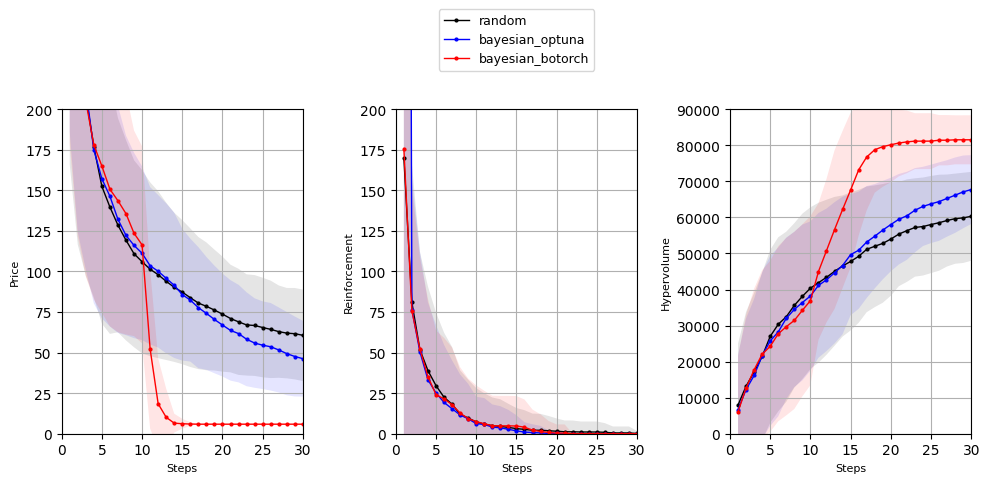

In [5]:
results_random_acc = np.zeros_like(results_random)
results_random_acc[:, :, :2] = np.minimum.accumulate(results_random[:, :, :2], axis=1)
results_random_acc[:, :, 2] = np.maximum.accumulate(results_random[:, :, 2], axis=1)

results_optuna_acc = np.zeros_like(results_optuna)
results_optuna_acc[:, :, :2] = np.minimum.accumulate(results_optuna[:, :, :2], axis=1)
results_optuna_acc[:, :, 2] = np.maximum.accumulate(results_optuna[:, :, 2], axis=1)

results_botorch_acc = np.zeros_like(results_botorch)
results_botorch_acc[:, :, :2] = np.minimum.accumulate(results_botorch[:, :, :2], axis=1)
results_botorch_acc[:, :, 2] = np.maximum.accumulate(results_botorch[:, :, 2], axis=1)

means_random = [
    np.mean(x, axis=0) for x in np.rollaxis(results_random_acc, 2)]
stds_random = [np.std(x, axis=0) for x in np.rollaxis(results_random_acc, 2)]

means_optuna = [
    np.mean(x, axis=0) for x in np.rollaxis(results_optuna_acc, 2)]
stds_optuna = [np.std(x, axis=0) for x in np.rollaxis(results_optuna_acc, 2)]

means_botorch = [
    np.mean(x, axis=0) for x in np.rollaxis(results_botorch_acc, 2)]
stds_botorch = [np.std(x, axis=0) for x in np.rollaxis(results_botorch_acc, 2)]

tmp = [[means_random, stds_random],
       [means_optuna, stds_optuna],
       [means_botorch, stds_botorch],
       ]

labels = ["random", "bayesian_optuna", "bayesian_botorch"]
colors = ["black", "blue", "red"]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

for idx0, (means, stds) in enumerate(tmp):
    for idx1, (mean, std) in enumerate(zip(means, stds)):
        ax[idx1].plot(
            range(1, n_exps_+1), mean, color=colors[idx0], linewidth=1, 
            label=labels[idx0], marker=".", markersize=4,)
        ax[idx1].fill_between(
            range(1, n_exps_+1), mean + std, mean - std, 
            facecolor=colors[idx0], alpha=0.1)

y_lims = [(0, 200), (0, 200), (0, 90000)]
y_labels = ["Price", "Reinforcement", "Hypervolume"]
for idx2 in range(3):
    ax[idx2].set_ylim(y_lims[idx2])
    ax[idx2].set_xlim([0, n_exps_])
    ax[idx2].xaxis.set_ticks(np.arange(0, n_exps_+1, 5))
    ax[idx2].set_xlabel("Steps", fontsize=8)
    ax[idx2].set_ylabel(y_labels[idx2], fontsize=8)
    ax[idx2].grid()

ax[1].legend(loc="lower center", bbox_to_anchor=(0, 1.1, 1, 0.2), ncol=1, fontsize=9)
plt.tight_layout()
plt.show()